In [3]:
# Проверка возможности использования xgbooster в основном, либо предварительно (2017-06-30)

In [4]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [5]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [6]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [7]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [362]:
binsData = 64

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
if False : #True :
    trDirI = trDirJPG
    teDirI = teDirJPG
    ttExt  = '.jpg'
else :
    trDirI = trDirTIF
    teDirI = teDirTIF
    ttExt  = '.tif'
trWork, teWork = '../Work/Train', '../Work/Test'
print (trDirI,teDirI, trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Data/train-tif-v2 ../Data/test-tif-v2 ../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [363]:
xx=os.listdir(trDirI); xx.sort(); xx[:6]

['train_0.tif',
 'train_1.tif',
 'train_10.tif',
 'train_100.tif',
 'train_1000.tif',
 'train_10000.tif']

In [364]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [365]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [366]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [367]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [368]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [370]:
def formImExt (nf, resize=(32,32), printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                nx = cv.resize(ni,resize)
            if (ni.shape[2]==4) :
                #r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
                r,g,b,n = cv.resize(ni[:,:,2],resize),cv.resize(ni[:,:,1],resize),cv.resize(ni[:,:,0],resize),cv.resize(ni[:,:,3],resize)
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

def formImHist (nf, size, printOK=False) :
    
    def hist1 (nf1,bins) :
        h,_ = np.histogram(nf1.ravel(),bins=bins)
        return h.tolist()
    
    def histN (nf,bins) :
        h = []
        for i in range(0,nf.shape[2]) :
            h = h + hist1(nf[:,:,i],bins=bins);
        return h
             
    nx = None
    try : 
        ni = cv.imread(nf,-1);
        if (ni is not None) :
            
            if printOK : print(nf,ni.shape)

            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : 
                print('----- error ---- shape:',ni.shape,nf);
            if  ni.shape[2]==3 :
                bins = [x for x in range(0,255+int(round(256.0/size)),int(round(256.0/size)))]
                nx = histN(ni,bins)
            if  ni.shape[2]==4 : 
                bins = [x for x in range(0,65535+int(round(65535.0/size)),int(round(65535.0/size)))]
                r,g,b,n = ni[:,:,2], ni[:,:,1], ni[:,:,0], ni[:,:,3]
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
                nx = histN(ni,bins)
            
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [371]:
trX, trY, i, size = [],[], 0, len(nameList)
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    nf = os.path.join(trDirI,nn+ttExt);
    nx = formImHist(nf,binsData,printOK=False)
    if (nx is not None) :
        #rr=np.save(os.path.join(trWork,nn+".npy"),nx);
        #trX.append(nn+".npy")
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)
#trXY=pd.DataFrame(trY); trXY['name']=trX; trXY.head()
#trXY.to_pickle(os.path.join(trWork,"listFiles.pkl"))

2017-07-01 23:34:39.757162 40479 40479
2017-07-01 23:39:50.515359 	 5000 	 train_4999
2017-07-01 23:44:20.947150 	 10000 	 train_9999
2017-07-01 23:48:22.180297 	 15000 	 train_14999
2017-07-01 23:52:21.322746 	 20000 	 train_19999
2017-07-01 23:56:17.223867 	 25000 	 train_24999
2017-07-02 00:00:05.227685 	 30000 	 train_29999
2017-07-02 00:03:53.482557 	 35000 	 train_34999
2017-07-02 00:07:42.385447 	 40000 	 train_39999
2017-07-02 00:08:03.259341
40479 (40479, 256) (40479, 17)


In [372]:
trX.shape,trY.shape

((40479, 256), (40479, 17))

In [373]:
np.save('../Work/train-data-XX'+str(binsData)+ttExt+'.npy',trX)
np.save('../Work/train-data-YY'+str(binsData)+ttExt+'.npy',trY)

In [374]:
del(trX); del(trY);

In [375]:
trX = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
trY = np.load('../Work/train-data-YY'+str(binsData)+ttExt+'.npy')
print(trX.shape,trY.shape)

(40479, 256) (40479, 17)


In [376]:
import xgboost as xgb

In [377]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,1])

In [378]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

results, bstList = [], []
for i in range(trY.shape[1]) :
    print ('Working: {}'.format(i))
    dtrain.set_label(trY[:,i])
    history = xgb.cv(param, dtrain, metrics=['auc'], verbose_eval=30, num_boost_round=1000, nfold=3, early_stopping_rounds=20) #,stratified=True,maximize=True)
    results.append(history)
    rvalidCV = {}
    watchlistCV  = [(dtrain,'train')]
    bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
    bstList.append(bst)
    

Working: 0
[0]	train-auc:0.924673+0.00530136	test-auc:0.910689+0.00803789
[30]	train-auc:0.986201+0.00054265	test-auc:0.952872+0.00199719
[60]	train-auc:0.993564+0.000382888	test-auc:0.952446+0.00131626
[0]	train-auc:0.930388	train-rmse:0.37935
[1]	train-auc:0.942746	train-rmse:0.303731
[2]	train-auc:0.951364	train-rmse:0.255736
[3]	train-auc:0.954756	train-rmse:0.224731
[4]	train-auc:0.957927	train-rmse:0.205094
[5]	train-auc:0.959817	train-rmse:0.193577
[6]	train-auc:0.961453	train-rmse:0.186519
[7]	train-auc:0.963828	train-rmse:0.181568
[8]	train-auc:0.966092	train-rmse:0.178421
[9]	train-auc:0.967606	train-rmse:0.175634
[10]	train-auc:0.968846	train-rmse:0.17318
[11]	train-auc:0.970464	train-rmse:0.171546
[12]	train-auc:0.971394	train-rmse:0.170483
[13]	train-auc:0.971922	train-rmse:0.169849
[14]	train-auc:0.972866	train-rmse:0.169194
[15]	train-auc:0.974516	train-rmse:0.167783
[16]	train-auc:0.975007	train-rmse:0.167392
[17]	train-auc:0.975759	train-rmse:0.166475
[18]	train-auc:0.

In [379]:
# save xgb models into files
for i in range(len(bstList)) :
    bstList[i].save_model('../Work/Models/model-'+str(100+i)+'-'+str(binsData)+ttExt+'.xgb')

In [380]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model('../Work/Models/model-'+str(100+i)+'-'+str(binsData)+ttExt+'.xgb')
bstList = bstList0
del bstList0
len(bstList)

17

In [381]:
#[(x['test-rmse-mean'].min(),x['test-rmse-mean'].argmin()) for x in results]

In [382]:
#[(x['test-rmse-mean'].min(),x['test-rmse-mean'].argmin()) for x in results]

In [161]:
[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 50

[(0.95933766666666676, 51),
 (0.97132033333333334, 70),
 (0.92636800000000008, 84),
 (0.97527066666666673, 52),
 (0.82370966666666667, 91),
 (0.93564866666666668, 41),
 (0.91020533333333331, 58),
 (0.84959400000000007, 84),
 (0.84758433333333338, 38),
 (0.98782933333333334, 197),
 (0.9787530000000001, 214),
 (0.95955733333333326, 49),
 (0.86465266666666662, 54),
 (0.98490033333333338, 55),
 (0.88952866666666663, 32),
 (0.87565166666666672, 27),
 (0.81941499999999989, 40)]

In [208]:
[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 75

[(0.95963833333333337, 30),
 (0.97144833333333336, 73),
 (0.92635233333333333, 109),
 (0.97506933333333334, 130),
 (0.82618333333333327, 151),
 (0.93428500000000003, 56),
 (0.91021033333333345, 56),
 (0.84739166666666665, 74),
 (0.84609366666666663, 31),
 (0.98742033333333323, 82),
 (0.97728066666666669, 190),
 (0.957928, 27),
 (0.86184966666666674, 40),
 (0.98402533333333331, 56),
 (0.88504333333333329, 28),
 (0.87253733333333328, 39),
 (0.83189766666666676, 36)]

In [233]:
[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 255

[(0.95898666666666665, 42),
 (0.97181966666666675, 152),
 (0.9253096666666667, 73),
 (0.97478400000000009, 114),
 (0.82098633333333326, 109),
 (0.92782300000000006, 36),
 (0.9083026666666667, 54),
 (0.8458106666666666, 37),
 (0.85382900000000006, 57),
 (0.98749666666666658, 226),
 (0.97769933333333336, 158),
 (0.95703633333333338, 26),
 (0.86158199999999996, 33),
 (0.98312966666666668, 57),
 (0.88108266666666657, 39),
 (0.87651833333333329, 58),
 (0.8118953333333333, 43)]

In [107]:
[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 64

[(0.95948733333333325, 32),
 (0.97256966666666667, 164),
 (0.92552966666666669, 47),
 (0.97550900000000007, 75),
 (0.82574866666666669, 133),
 (0.93550366666666684, 40),
 (0.91033400000000009, 44),
 (0.84866999999999992, 75),
 (0.85204333333333337, 23),
 (0.98744266666666658, 125),
 (0.97777599999999998, 123),
 (0.9568983333333333, 64),
 (0.86091600000000001, 25),
 (0.98515599999999992, 77),
 (0.88546999999999987, 32),
 (0.87672866666666671, 28),
 (0.82038299999999997, 21)]

In [383]:
trYP = []
for bstI in bstList :
    trYP1 = bstI.predict(dtrain);
    trYP.append(trYP1)
trYP = np.array(trYP).T
type(trYP),trYP.shape

(numpy.ndarray, (40479, 17))

In [384]:
trYPP= trYP.copy() # вероятностный массив
trYP[trYP<0.5] = 0
trYP[trYP!=0]  = 1

In [385]:
for i in range(trYP.shape[1]) :
    print ('#{} accuracy={} precision={} recall={} ros_auc={} fbeta2={} not={}'.format(i, 
                                           skm.accuracy_score(trY[:,i],trYP[:,i]), 
                                           skm.precision_score(trY[:,i],trYP[:,i]), 
                                           skm.recall_score(trY[:,i],trYP[:,i]), 
                                           skm.roc_auc_score(trY[:,i],trYP[:,i]), 
                                           skm.fbeta_score(trY[:,i],trYP[:,i],beta=2),
                                           len(trYP[trYP[:,i]<>trY[:,i],i])))
    #print (skm.confusion_matrix(trY[:,i],trYP[:,i]))
    #fpr,tpr,thr = skm.roc_curve(trY[:,i],trYP[:,i]); print (len(thr),len(fpr),len(trYP[:,i]))
    #plt.plot(fpr,tpr); plt.show()

#0 accuracy=0.968428073816 precision=0.84258812168 recall=0.647015202076 ros_auc=0.819193377334 fbeta2=0.678513103663 not=1278
#1 accuracy=0.980854270115 precision=0.984900480439 recall=0.994588542639 ros_auc=0.900868108137 fbeta2=0.992635712537 not=775
#2 accuracy=0.907062921515 precision=0.879290465632 recall=0.805034510759 ros_auc=0.878355204535 fbeta2=0.818865119352 not=3762
#3 accuracy=0.957780577583 precision=0.96008953168 recall=0.980654918927 ros_auc=0.942228189875 fbeta2=0.976471659522 not=1709
#4 accuracy=0.916598730206 precision=0.880875967529 recall=0.629604641749 ros_auc=0.805261374945 fbeta2=0.667696974901 not=3376
#5 accuracy=0.956224215025 precision=0.880952380952 recall=0.596448087432 ros_auc=0.7942179599 fbeta2=0.63763290104 not=1772
#6 accuracy=0.923614713802 precision=0.8641216908 recall=0.732003469211 ros_auc=0.851668853835 fbeta2=0.755093172465 not=3092
#7 accuracy=0.908372242397 precision=0.784023668639 recall=0.236765691311 ros_auc=0.614327515396 fbeta2=0.275181

In [387]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-2350)/40497.0, (40497.0-1709)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((2350, 17), [3, 10, 0, 9], 0.9419710101982863, 0.9577993431612218)

In [388]:
trY[trYP[10]==1].shape

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 40479 but corresponding boolean dimension is 17
  if __name__ == '__main__':


(3, 17)

In [389]:
# Построение важности полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

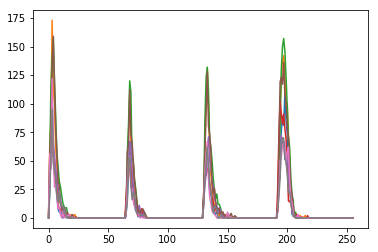

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [390]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


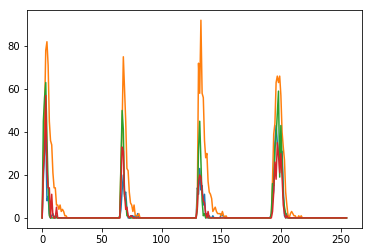

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [391]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


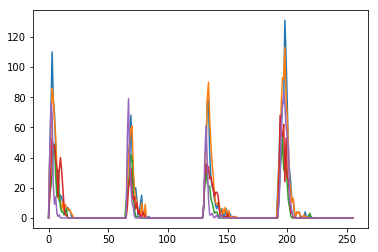

['primary', 'cloudy', 'conventional_mine', 'artisinal_mine', 'blow_down']

In [392]:
xx = [1,9,11,13,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [393]:
# Попытка посчитать уровень прохождения для каждого признака

In [394]:
ixx,iacc = [], []
for i in range(trY.shape[1]) :
    max, maxxx = 0.0, 0.0
    for xx in range(0,101) :
        tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
        tempYP[tempYP<float(xx/100.0)] = 0
        tempYP[tempYP>0.0]   = 1
        temp = skm.accuracy_score(trY[:,i],tempYP)
        #print(float(xx/10.0),temp)
        if (temp>max) : 
            max = temp; maxxx = float(xx)
            temp = skm.confusion_matrix(trY[:,i],tempYP);
            minloss = temp[0][1]+temp[1][0]
    ixx.append(maxxx)
    tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
    tempYP[tempYP<0.5]   = 0
    tempYP[tempYP>0.0]   = 1
    temp = skm.accuracy_score(trY[:,i],tempYP)
    minloss05 = skm.confusion_matrix(trY[:,i],tempYP);
    minloss05 = minloss05[0][1]+minloss05[1][0]
    iacc.append((maxxx,max,temp,minloss,minloss05))
ixx
#[ixx[xx] for xx in wr]

[42.0,
 56.0,
 44.0,
 53.0,
 39.0,
 40.0,
 46.0,
 41.0,
 17.0,
 42.0,
 46.0,
 14.0,
 30.0,
 24.0,
 22.0,
 22.0,
 15.0]

In [395]:
iacc

[(42.0, 0.97047851972627786, 0.96842807381605278, 1195, 1278),
 (56.0, 0.98157069097556759, 0.98085427011536841, 746, 775),
 (44.0, 0.90814990488895475, 0.90706292151485957, 3718, 3762),
 (53.0, 0.95839818177326519, 0.95778057758343838, 1684, 1709),
 (39.0, 0.91847624694285923, 0.91659873020578575, 3300, 3376),
 (40.0, 0.95881815262234737, 0.95622421502507471, 1667, 1772),
 (46.0, 0.92643098890782871, 0.92361471380221838, 2978, 3092),
 (41.0, 0.91180612169272957, 0.90837224239729242, 3570, 3709),
 (17.0, 0.99666493737493511, 0.99528150398972304, 135, 191),
 (42.0, 0.9926381580572643, 0.99211937053780974, 298, 319),
 (46.0, 0.96111564020850315, 0.96086859853257245, 1574, 1584),
 (14.0, 1.0, 1.0, 0, 0),
 (30.0, 0.988141999555325, 0.98455989525432941, 480, 625),
 (24.0, 1.0, 0.99997529583240696, 0, 1),
 (22.0, 0.99431804145359326, 0.99256404555448507, 230, 301),
 (22.0, 0.99315694557671874, 0.99169939968872745, 277, 336),
 (15.0, 1.0, 0.99990118332962774, 0, 4)]

In [396]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [397]:
nameAsk = os.listdir(teDirI); print(len(nameAsk))
trOX, trOY, i, size = [], [], 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    nf = os.path.join(teDirI,nn);
    nx = formImHist(nf,binsData) #,printOK=True)
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)

print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-07-02 00:22:15.798298 61191 61191
2017-07-02 00:27:48.381733 	 5000 	 test_15649.tif
2017-07-02 00:32:43.967615 	 10000 	 test_32423.tif
2017-07-02 00:37:10.297015 	 15000 	 test_36264.tif
2017-07-02 00:41:18.664002 	 20000 	 test_10894.tif
2017-07-02 00:45:23.928440 	 25000 	 file_9502.tif
2017-07-02 00:49:19.240335 	 30000 	 file_14128.tif
2017-07-02 00:53:04.589600 	 35000 	 file_17389.tif
2017-07-02 00:56:44.155740 	 40000 	 test_19356.tif
2017-07-02 01:00:18.341299 	 45000 	 test_10134.tif
2017-07-02 01:03:48.579482 	 50000 	 test_24243.tif
2017-07-02 01:07:19.690403 	 55000 	 test_7049.tif
2017-07-02 01:10:45.684732 	 60000 	 file_10482.tif
2017-07-02 01:11:33.167729


In [398]:
trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trOX.shape,trOY.shape)

61191 (61191, 256) (61191,)


In [399]:
#trOX[20],trOY[20]

In [400]:
# Saving & Loading

In [401]:
np.save('../Work/test-data-XX'+str(binsData)+ttExt+'.npy',trOX)
np.save('../Work/test-data-YY'+str(binsData)+ttExt+'.npy',trOY)

In [402]:
trOX = np.load('../Work/test-data-XX'+str(binsData)+ttExt+'.npy')
trOY = np.load('../Work/test-data-YY'+str(binsData)+ttExt+'.npy')
print(trOX.shape,trOY.shape)

(61191, 256) (61191,)


In [403]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [404]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [405]:
np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [406]:
trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
trP.shape

(61191, 17)

In [407]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx)/100.0 #np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.56, 0.44, 2.0, 0.39, 0.4, 0.46, 0.41, 0.17, 2.0, 2.0, 0.14, 0.3, 0.24, 0.22, 0.22, 0.15]


In [408]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary agriculture habitation road'] 
 [ 2.    0.56  0.44  2.    0.39  0.4   0.46  0.41  0.17  2.    2.    0.14
  0.3   0.24  0.22  0.22  0.15] [  7.56122312e-03   9.99360859e-01   1.47644868e-02   9.84987438e-01
   1.22814402e-02   2.07584957e-03   1.16230743e-02   7.64187751e-03
   7.03619618e-04   8.80468069e-05   4.07891069e-03   7.68162772e-06
   2.08476256e-03   3.05504363e-05   7.44206179e-03   5.02857380e-03
   1.05890722e-04]


In [409]:
print(labels)
print(trM.tolist())
np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.56, 0.44, 2.0, 0.39, 0.4, 0.46, 0.41, 0.17, 2.0, 2.0, 0.14, 0.3, 0.24, 0.22, 0.22, 0.15]


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]], dtype=float32)

In [410]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-02-01-12-57
